In [ ]:
# this notebook is "scratchpad" code, as part of feature inclusion/exclusion exploration

In [1]:
"""
Created on Wed Jun 19 11:48:32 2019

@author: Andrew Welsh

This notebook is for doing a model fit to the historical data, then save the fitted model via joblib. The data must 
be extracted via SQL prior to inclusion in this notebook (until a data connection directly to the database is configured),
then saved via CSV, which is read here. 

The parameter tuning for this model fit is accomplished with the churn_grid_search_parameter_tuning notebook

Intended use is production model re-fitting process every 6 months, as well as the initial model fit.

Output: saved model files
"""

import pandas as pd
import churn_common as p #imports F2 score function, model_fit function

# imported data already has nulls cleaned and unused columns dropped
# churn_dedi_model_training_fit.csv is output from 'churn_dedi_model_training_fit.py' python script
dedicated = pd.read_csv('churn_dedi_model_training_fit.csv', encoding='ISO-8859-1')

print('Query complete')
pd.options.display.max_columns = None

Query complete


In [28]:
dedicated['time_month_key'].max()

201906

In [21]:
# prior testing 

#index column from CSV is imported as a separate column, labeled 'Unnamed: 0', therefore must be dropped before model fit
dedicated.drop(['Unnamed: 0'], axis=1, inplace=True)
#dedicated = dedicated.iloc[1:3000, :].copy() #select first 3k rows for fast testing

#Months are hard-coded here, use df['time_month_key'].max() above to find max TMK, configure eval set to be 3 most recent 
#months with enough time to determine churn (6mo per definition)
#Example: max TMK 201812; eval data is max TMK:201812 - 6mo - 3mo = 201806. For 3 month window, 201804 to 201806 inclusive, 
# dedicated_train is -6mo earlier from min TMK in eval data, i.e. 201804 - 6 = 201710 and earlier

#min TMK is 201601 max TMK is 201906, as of Aug 6 2019 for churn dedicated.

#define model training dataset, set to TMK <= max(TMK)-14 (see above notes for reasoning)
dedicated_train = dedicated.loc[dedicated['time_month_key']<=201801]
dedicated_train.set_index(['account_number','time_month_key'])

#evaluation dataset of most recent 3 months with churn results, +6mo from training dataset, it's own max -6mo from max TMK
dedicated_eval = dedicated.loc[(dedicated['time_month_key']>=201807) & (dedicated['time_month_key']<=201812)]
dedicated_eval.set_index(['account_number','time_month_key'])

#the table head for the eval data should output below. Most accounts should have 3 rows each (3 latest TMKs).

average_invoiced_last_12_months  target  \
account_number time_month_key                                            
1000165        201810                              1542.530000       0   
               201811                              1542.530000       0   
               201812                              1542.530000       0   
1000171        201810                             57194.642500       0   
               201811                             57031.956666       0   
               201812                             56987.703333       0   
1000197        201810                              2265.760000       0   
               201811                              2275.645000       0   
               201812                              2287.448333       0   
1000403        201810                              2726.670000       0   
               201811                              2648.795000       1   
1000516        201810                             15326.950000       0   
               201811                             15602.826666       0   
               201812                             15877.720833       0   
1000740        201810                             33428.135833       0   
               201811                             33532.778333       0   
               201812                             33637.352500       0   
1000791        201810                             42763.025000       1   
               201811                             37878.679166       1   
               201812                             33004.828333       1   
1000806        201810                               821.815000       0   
               201811                               777.940000       0   
               201812                               778.948333       0   
1000815        201810                              1818.755833       0   
               201811                              1818.995000       0   
               201812                              1826.230000       0   
1001062        201810                               819.000000       0   
               201811                               819.000000       0   
               201812                               833.075833       0   
1001106        201810                              1875.267500       0   
...                                                        ...     ...   
998576         201811                              9503.499166       0   
               201812                              9286.245000       0   
998749         201810                               611.555000       0   
               201811                               624.174166       0   
               201812                               641.161666       0   
998812         201810                             15821.445000       0   
               201811                             15977.106666       1   
               201812                             16120.237500       1   
998890         201810                              5838.210833       0   
               201811                              5842.378333       0   
               201812                              5841.678333       0   
998901         201810                              2839.930000       0   
               201811                              2839.930000       0   
               201812                              2865.813333       0   
998964         201810                             17603.839166       1   
999037         201810                              5981.669166       0   
               201811                              6409.589166       0   
               201812                              6568.120000       0   
999426         201810                               641.074166       0   
               201811                               649.648333       0   
               201812                               658.222500       0   
999839         201810              

In [22]:
#split datasets into low-med-hi revenue segments
#training dataset
dedicated_train_low, dedicated_train_mid, dedicated_train_hi = p.split_df_revenue_segments(dedicated_train, 'average_invoiced_last_12_months')

#eval dataset
dedicated_eval_low, dedicated_eval_mid, dedicated_eval_hi = p.split_df_revenue_segments(dedicated_eval, 'average_invoiced_last_12_months')

In [23]:
#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================


#for repeatable results, set seed equal to an integer; for random assignment, set seed to None
seed = None

dedicated_train_low_rus = p.AndrewsRandomUnderSampler(dedicated_train_low, 'target', seed)
dedicated_train_mid_rus = p.AndrewsRandomUnderSampler(dedicated_train_mid, 'target', seed)
dedicated_train_hi_rus = p.AndrewsRandomUnderSampler(dedicated_train_hi, 'target', seed)

print('Minority class resampling complete')

Minority class resampling complete


In [24]:
exclude_col = ['target'
             ,'average_invoiced_last_12_months'
             ,'account_number'
             ,'time_month_key'
             ,'total_invoiced_in_month'
#            ,'defection_flag'
              #features that had total gain less than 3.0
               
              ]

include_col = ['3 mth pct change number of device_status = computer no longer active'
                ,'3 mth pct change number of devices active status - active'
                ,'3 mth pct change number of devices online status - online'
                ,'average active device tenure months'
                ,'average value of opportunities last 3 months'
                ,'average value of opportunities last 6 months'
                ,'avg credit memo in last 6 months'
                ,'avg monthly number of - sku_description =  included bandwidth - 6 mth to 1 mth'
                ,'avg monthly number of - sku_description =  raid 1 - 6 mth to 1 mth'
                ,'avg monthly number of - sku_name =  included bandwidth - 6 mth to 1 mth'
                ,'avg monthly number of - sku_name =  ip allocation - 6 mth to 1 mth'
                ,'avg mthly num of invoiced items in last 3 months vs prior 3 months'
                ,'avg mthly num of invoiced items in last 6 months'
                ,'how many units - bandwidth overages'
                ,'how many units - san'
                ,'how many units - server'
                ,'multi_stage_in_month_cnt'
                ,'num opportunities last 3 months'
                ,'num opportunities won last 3 months'
                ,'num opportunities won last 6 months'
                ,'num opps competitors - other'
                ,'num opps econnect_received - true'
                ,'num opps on_demand_reconciled - true'
                ,'num tickets ticket category - null 1mo'
                ,'number of device_status = computer no longer active'
                ,'number of other device_status'
                ,'pct of device_status = computer no longer active'
                ,'pct of invoice - bandwidth overages'
                ,'pct of invoice - rackspace email'
                ,'pct of other device_status'
                ,'pct opportunities lost last 3 months'
                ,'pct opportunities lost last 6 months'
                ,'pct opportunities won last 3 months'
                ,'pct opportunities won last 6 months'
                ,'per unit price - firewall'
                ,'per unit price - threat manager'
                ,'rating_detractor_to_detractor_num'
                ,'shortest active device tenure months'
                ,'total invoiced in last 3 months vs prior 3 months'
                ,'total value of opportunities last 3 months'
                ,'total value of opportunities last 6 months'
               ]
predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])

#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

train ready
eval ready


In [25]:
#import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_auc_score
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import time
import datetime
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


Model Fit Start time
2019-09-25 20:32:55




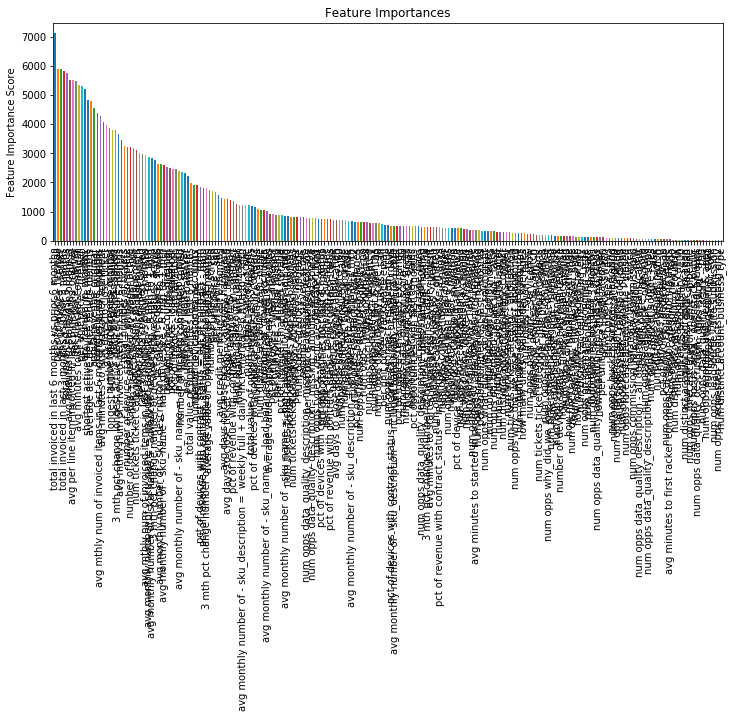

total invoiced in last 6 months vs prior 6 months    7132
pct of invoice - firewall                            5922
pct of invoice - server                              5903
total invoiced in last 3 months vs prior 3 months    5828
total invoiced in last 6 months                      5781
dtype: int64
Confusion matrix for evaluation data:
 [[5345  383]
 [ 288  484]]
Precision-Specificity 
 0.558246828143022
Recall-Sensitivity 
 0.6269430051813472
F 2 Score 
 0.6118836915297093



Model Fit End time
2019-09-25 20:35:29

Model Fit Start time
2019-09-25 20:35:29




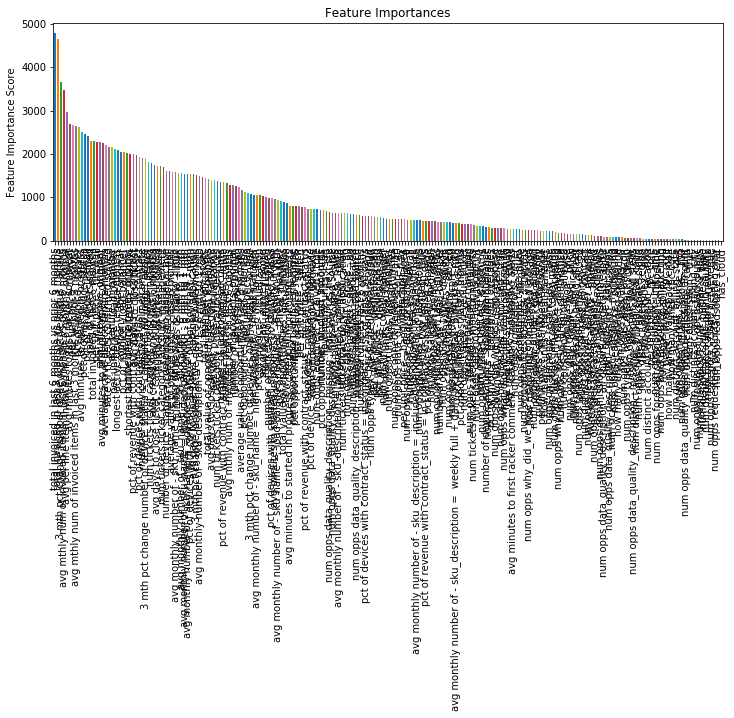

total invoiced in last 6 months vs prior 6 months                     4778
total invoiced in last 3 months vs prior 3 months                     4661
3 mth pct change number of devices active status - active             3655
avg mthly num of invoiced items in last 6 months vs prior 6 months    3482
avg per line item invoiced in last 6 months_original                  2959
dtype: int64
Confusion matrix for evaluation data:
 [[1725  158]
 [  95  194]]
Precision-Specificity 
 0.5511363636363636
Recall-Sensitivity 
 0.671280276816609
F 2 Score 
 0.643236074270557



Model Fit End time
2019-09-25 20:36:41


In [26]:
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
#Model run 
#==================================================================================================================
#==================================================================================================================
#==================================================================================================================
seed = 17
xgb_final_low = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.9,
        gamma=0, 
        learning_rate=0.02,
        max_delta_step=2, 
        max_depth=14, 
        min_child_weight=0, 
        missing=None,
        n_estimators=2000, 
        random_state=seed,
        reg_alpha=0.1,
        reg_lambda=1,
        scale_pos_weight=1,
        silent=True,
        subsample=0.7,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1
        )

xgb_final_mid = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=1,
        colsample_bytree=0.8,
        gamma=0, 
        learning_rate=0.01,
        max_delta_step=1, 
        max_depth=11, 
        min_child_weight=1, 
        missing=None,
        n_estimators=2000, 
        random_state=seed,
        reg_alpha=0.01,
        reg_lambda=0.1,
        scale_pos_weight=1,
        subsample=0.7,
        verbosity=0,
        eval_metric='auc',
        objective='binary:logistic',
        nthread=-1
        )

xgb_final_hi = XGBClassifier(
        base_score=0.5, 
        booster='gbtree', 
        colsample_bylevel=1,
        colsample_bytree=0.7, 
        eval_metric='auc', 
        gamma=0,
        learning_rate=0.005, 
        max_delta_step=0, 
        max_depth=13, 
        max_features=13,
        min_child_weight=1, 
        missing=None, 
        n_estimators=1500, 
        n_jobs=1,
        nthread=-1, 
        objective='binary:logistic', 
        random_state=seed,
        reg_alpha=0.1, 
        reg_lambda=1e-05, 
        scale_pos_weight=1, 
        seed=seed,
        silent=True, 
        subsample=0.8
        )

#p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
#         x_eval_low, y1_eval_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors)

#F2 scores with basic gridsearch on n_estimators and learning_rate: .523, .580, .675 (L, M, H)
#next: .526, .622, .643 (with gridsearched min_child_weight, max_depth, max_delta_step)

In [14]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
#'gain' is the average GINI gain for that feature when used in a split

fi_low_gain = pd.DataFrame(xgb_final_low.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_low_gain = fi_low_gain.T #transpose result
fi_low_gain = fi_low_gain.sort_values([0], ascending=[True]).copy()
fi_low_gain.to_excel('1feat_imp_low.xlsx')

fi_mid_gain = pd.DataFrame(xgb_final_mid.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_mid_gain = fi_mid_gain.T #transpose result
fi_mid_gain = fi_mid_gain.sort_values([0], ascending=[True]).copy()
fi_mid_gain.to_excel('1feat_imp_mid.xlsx')

fi_hi_gain = pd.DataFrame(xgb_final_hi.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_hi_gain = fi_hi_gain.T #transpose result
fi_hi_gain = fi_hi_gain.sort_values([0], ascending=[True]).copy()
fi_hi_gain.to_excel('1feat_imp_hi.xlsx')


train ready
eval ready

Model Fit Start time
2019-09-25 20:00:54




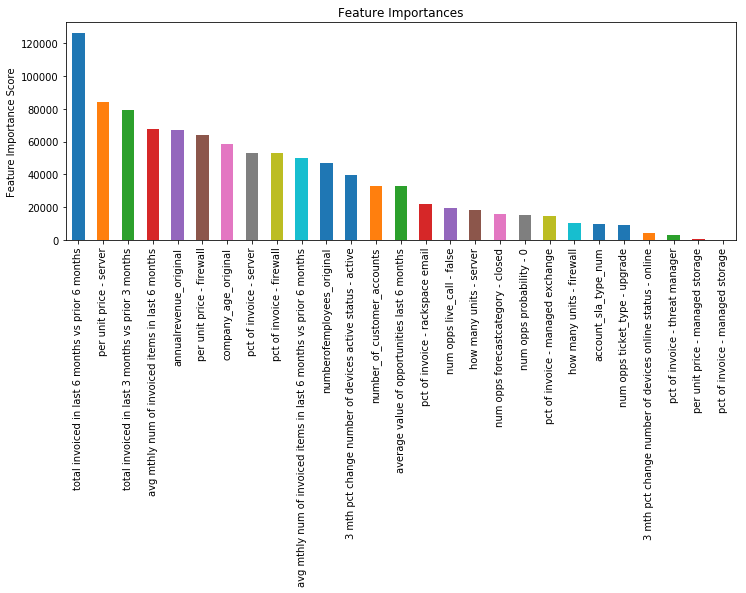

total invoiced in last 6 months vs prior 6 months    126517
per unit price - server                               83888
total invoiced in last 3 months vs prior 3 months     79512
avg mthly num of invoiced items in last 6 months      67478
annualrevenue_original                                66954
dtype: int64
Confusion matrix for evaluation data:
 [[19669   836]
 [ 1043  1053]]
Precision-Specificity 
 0.5574377977766014
Recall-Sensitivity 
 0.5023854961832062
F 2 Score 
 0.5125085174729875



Model Fit End time
2019-09-25 20:04:26

Model Fit Start time
2019-09-25 20:04:26




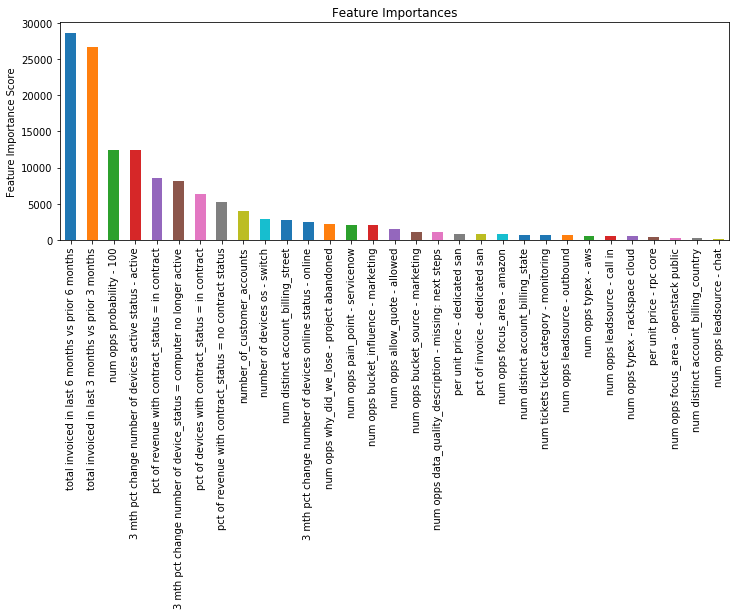

total invoiced in last 6 months vs prior 6 months            28673
total invoiced in last 3 months vs prior 3 months            26676
num opps probability - 100                                   12500
3 mth pct change number of devices active status - active    12388
pct of revenue with contract_status = in contract             8545
dtype: int64
Confusion matrix for evaluation data:
 [[5104  624]
 [ 291  481]]
Precision-Specificity 
 0.43529411764705883
Recall-Sensitivity 
 0.6230569948186528
F 2 Score 
 0.5735750059623181



Model Fit End time
2019-09-25 20:05:22

Model Fit Start time
2019-09-25 20:05:22




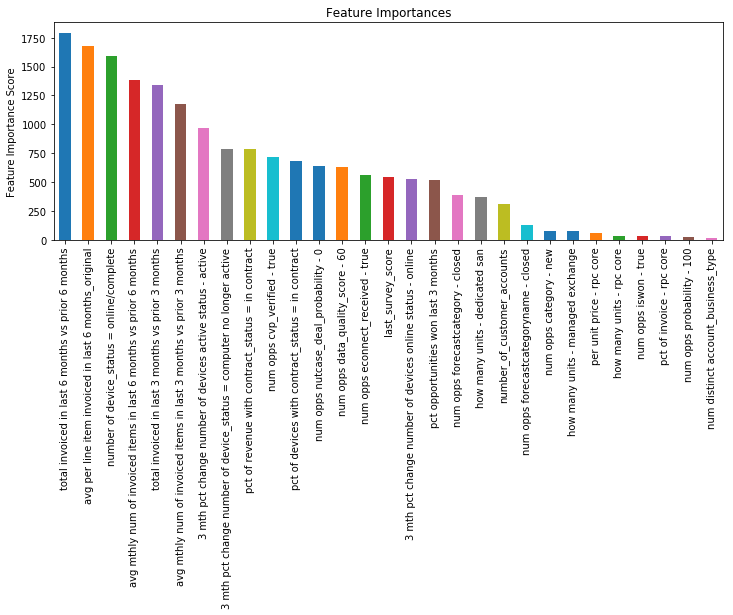

total invoiced in last 6 months vs prior 6 months                     1793
avg per line item invoiced in last 6 months_original                  1679
number of device_status = online/complete                             1590
avg mthly num of invoiced items in last 6 months vs prior 6 months    1384
total invoiced in last 3 months vs prior 3 months                     1343
dtype: int64
Confusion matrix for evaluation data:
 [[1610  273]
 [  75  214]]
Precision-Specificity 
 0.4394250513347023
Recall-Sensitivity 
 0.740484429065744
F 2 Score 
 0.6512477175897748



Model Fit End time
2019-09-25 20:05:26


In [9]:
#based on list of features with gain <3.0 in the high-revenue accounts, eliminate those features from the dataset, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

exclude_col = ['target'
               ,'total invoiced in last 6 months'
               ,'account_number'
               ,'time_month_key'
               ,'avg_6mo_eval'
               ,'avg_9mo_eval'
               ,'past_6mo_baseline'
#                ,'account_sub_type','account_segment'
#                ,'total invoiced in last 6 months vs prior 6 months'
#                ,'total invoiced in last 3 months vs prior 3 months'
#                ,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
#                ,'avg mthly num of invoiced items in last 6 months'
#                ,'number of device_status = online/complete'
               
               #features that had total gain less than 3.0

              ]


include_col_low = [
    'num opps probability - 0'
,'pct of invoice - threat manager'
,'how many units - firewall'
,'avg mthly num of invoiced items in last 6 months'
,'num opps live_call - false'
,'pct of invoice - managed exchange'
,'average value of opportunities last 6 months'
,'num opps ticket_type - upgrade'
,'account_sla_type_num'
,'company_age_original'
,'per unit price - server'
,'per unit price - firewall'
,'num opps forecastcategory - closed'
,'numberofemployees_original'
,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
,'annualrevenue_original'
,'per unit price - managed storage'
,'pct of invoice - firewall'
,'how many units - server'
,'pct of invoice - server'
,'pct of invoice - rackspace email'
,'total invoiced in last 3 months vs prior 3 months'
,'pct of invoice - managed storage'
,'3 mth pct change number of devices active status - active'
,'total invoiced in last 6 months vs prior 6 months'
,'3 mth pct change number of devices online status - online'
,'number_of_customer_accounts'


               ]

include_col_mid = [
'num opps probability - 100'
,'num opps leadsource - chat'
,'num opps pain_point - servicenow'
,'pct of revenue with contract_status = no contract status'
,'num opps allow_quote - allowed'
,'num opps why_did_we_lose - project abandoned'
,'num opps leadsource - call in'
,'num distinct account_billing_street'
,'num opps focus_area - openstack public'
,'num opps bucket_source - marketing'
,'num opps leadsource - outbound'
,'num opps bucket_influence - marketing'
,'num opps data_quality_description - missing: next steps'
,'pct of invoice - dedicated san'
,'num distinct account_billing_state'
,'number of devices os - switch'
,'num opps typex - aws'
,'num tickets ticket category - monitoring'
,'per unit price - rpc core'
,'pct of revenue with contract_status = in contract'
,'3 mth pct change number of device_status = computer no longer active'
,'per unit price - dedicated san'
,'num opps typex - rackspace cloud'
,'num opps focus_area - amazon'
,'num distinct account_billing_country'
,'total invoiced in last 6 months vs prior 6 months'
,'pct of devices with contract_status = in contract'
,'3 mth pct change number of devices active status - active'
,'3 mth pct change number of devices online status - online'
,'total invoiced in last 3 months vs prior 3 months'
,'number_of_customer_accounts'
    
       
]

include_col_hi = [
'3 mth pct change number of device_status = computer no longer active'
,'avg per line item invoiced in last 6 months_original'
,'avg mthly num of invoiced items in last 3 months vs prior 3 months'
,'num opps econnect_received - true'
,'number of device_status = online/complete'
,'how many units - dedicated san'
,'num opps data_quality_score - 60'
,'how many units - managed exchange'
,'num opps category - new'
,'pct opportunities won last 3 months'
,'how many units - rpc core'
,'per unit price - rpc core'
,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
,'num distinct account_business_type'
,'num opps cvp_verified - true'
,'last_survey_score'
,'num opps nutcase_deal_probability - 0'
,'pct of invoice - rpc core'
,'3 mth pct change number of devices active status - active'
,'3 mth pct change number of devices online status - online'
,'num opps forecastcategory - closed'
,'num opps forecastcategoryname - closed'
,'num opps iswon - true'
,'total invoiced in last 6 months vs prior 6 months'
,'pct of revenue with contract_status = in contract'
,'pct of devices with contract_status = in contract'
,'total invoiced in last 3 months vs prior 3 months'
,'number_of_customer_accounts'
,'num opps probability - 100'
            

]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors_mid]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors_hi]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors_hi)


#F2 scores with basic gridsearch on n_estimators and learning_rate: .517, .577, .667 (L, M, H)
#F2 scores with basic gridsearch on n_estimators and learning_rate: .518, .567, .659 (L, M, H)
#F2 scores with deflection flag NOT included: .511, .591, .632

In [16]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
#'gain' is the average GINI gain for that feature when used in a split
#re-run for the first iteration of eliminated features
fi_low_gain = pd.DataFrame(xgb_final_low.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_low_gain = fi_low_gain.T #transpose result
fi_low_gain = fi_low_gain.sort_values([0], ascending=[True]).copy()
fi_low_gain.to_excel('2feat_imp_low.xlsx')

fi_mid_gain = pd.DataFrame(xgb_final_mid.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_mid_gain = fi_mid_gain.T #transpose result
fi_mid_gain = fi_mid_gain.sort_values([0], ascending=[True]).copy()
fi_mid_gain.to_excel('2feat_imp_mid.xlsx')

fi_hi_gain = pd.DataFrame(xgb_final_hi.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_hi_gain = fi_hi_gain.T #transpose result
fi_hi_gain = fi_hi_gain.sort_values([0], ascending=[True]).copy()
fi_hi_gain.to_excel('2feat_imp_hi.xlsx')


train ready
eval ready

Model Fit Start time
2019-09-18 20:33:19




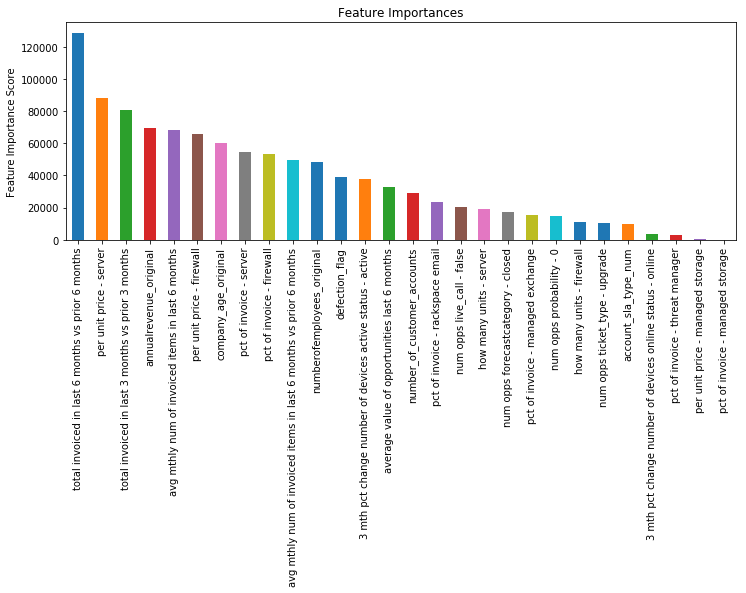

total invoiced in last 6 months vs prior 6 months    128704
per unit price - server                               87931
total invoiced in last 3 months vs prior 3 months     80404
annualrevenue_original                                69400
avg mthly num of invoiced items in last 6 months      68136
dtype: int64
Confusion matrix for evaluation data:
 [[19799   706]
 [  749  1347]]
Precision-Specificity 
 0.6561130053580126
Recall-Sensitivity 
 0.6426526717557252
F 2 Score 
 0.6453003736705949



Model Fit End time
2019-09-18 20:36:48

Model Fit Start time
2019-09-18 20:36:48




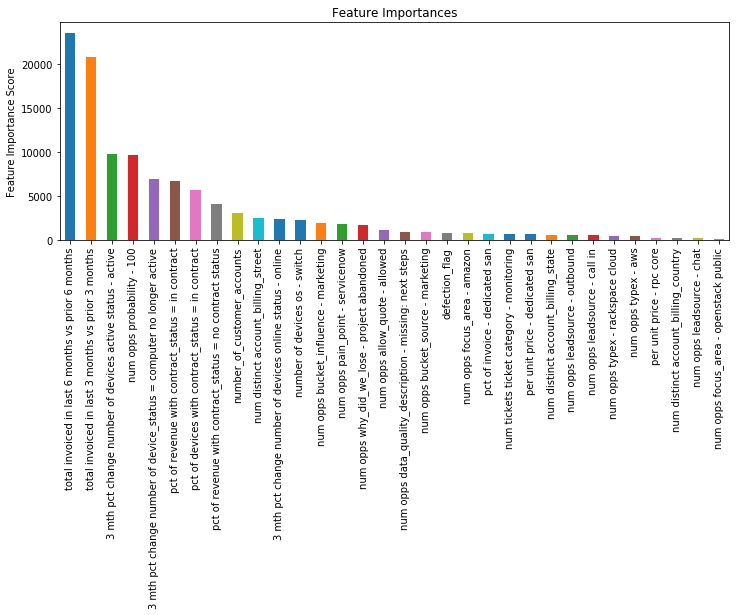

total invoiced in last 6 months vs prior 6 months                       23542
total invoiced in last 3 months vs prior 3 months                       20813
3 mth pct change number of devices active status - active                9723
num opps probability - 100                                               9631
3 mth pct change number of device_status = computer no longer active     6857
dtype: int64
Confusion matrix for evaluation data:
 [[5144  584]
 [ 251  521]]
Precision-Specificity 
 0.47149321266968325
Recall-Sensitivity 
 0.6748704663212435
F 2 Score 
 0.6212735511566896



Model Fit End time
2019-09-18 20:37:27

Model Fit Start time
2019-09-18 20:37:27




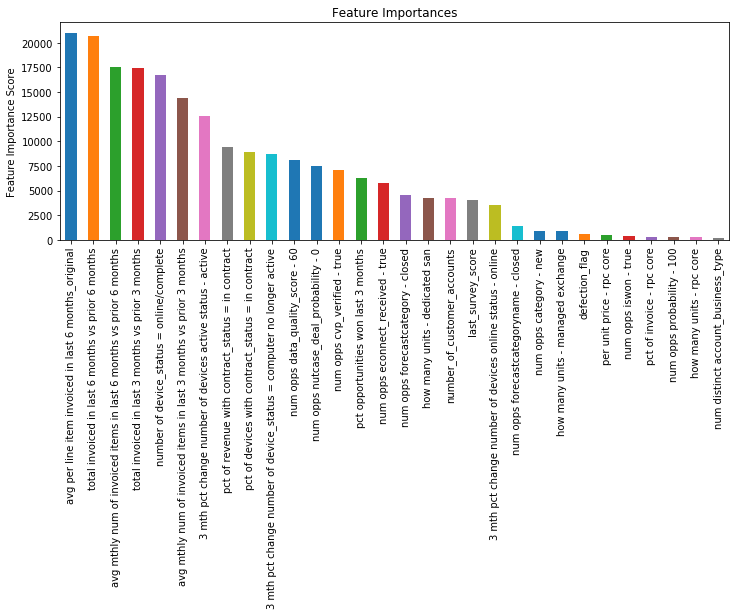

avg per line item invoiced in last 6 months_original                  21018
total invoiced in last 6 months vs prior 6 months                     20694
avg mthly num of invoiced items in last 6 months vs prior 6 months    17588
total invoiced in last 3 months vs prior 3 months                     17435
number of device_status = online/complete                             16692
dtype: int64
Confusion matrix for evaluation data:
 [[1666  217]
 [  89  200]]
Precision-Specificity 
 0.47961630695443647
Recall-Sensitivity 
 0.6920415224913494
F 2 Score 
 0.6357279084551812



Model Fit End time
2019-09-18 20:38:02


In [11]:
#2nd round of elimination
#based on list of features with gain <3.0 in the high-revenue accounts, eliminate those features from the dataset, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

exclude_col = ['target'
               ,'total invoiced in last 6 months'
               ,'account_number'
               ,'time_month_key'
               ,'avg_6mo_eval'
               ,'avg_9mo_eval'
               ,'past_6mo_baseline'
#                ,'account_sub_type','account_segment'
#                ,'total invoiced in last 6 months vs prior 6 months'
#                ,'total invoiced in last 3 months vs prior 3 months'
#                ,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
#                ,'avg mthly num of invoiced items in last 6 months'
#                ,'number of device_status = online/complete'
               
               #features that had total gain less than 3.0

              ]


include_col_low = [
    'num opps probability - 0'
,'pct of invoice - threat manager'
,'how many units - firewall'
,'avg mthly num of invoiced items in last 6 months'
,'num opps live_call - false'
,'pct of invoice - managed exchange'
,'average value of opportunities last 6 months'
,'num opps ticket_type - upgrade'
,'account_sla_type_num'
,'company_age_original'
,'per unit price - server'
,'per unit price - firewall'
,'num opps forecastcategory - closed'
,'numberofemployees_original'
,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
,'annualrevenue_original'
,'per unit price - managed storage'
,'pct of invoice - firewall'
,'how many units - server'
,'pct of invoice - server'
,'pct of invoice - rackspace email'
,'total invoiced in last 3 months vs prior 3 months'
,'pct of invoice - managed storage'
,'3 mth pct change number of devices active status - active'
,'total invoiced in last 6 months vs prior 6 months'
,'3 mth pct change number of devices online status - online'
,'number_of_customer_accounts'
,'defection_flag'
]

include_col_mid = [
'num opps probability - 100'
,'num opps leadsource - chat'
,'num opps pain_point - servicenow'
,'pct of revenue with contract_status = no contract status'
,'num opps allow_quote - allowed'
,'num opps why_did_we_lose - project abandoned'
,'num opps leadsource - call in'
,'num distinct account_billing_street'
,'num opps focus_area - openstack public'
,'num opps bucket_source - marketing'
,'num opps leadsource - outbound'
,'num opps bucket_influence - marketing'
,'num opps data_quality_description - missing: next steps'
,'pct of invoice - dedicated san'
,'num distinct account_billing_state'
,'number of devices os - switch'
,'num opps typex - aws'
,'num tickets ticket category - monitoring'
,'per unit price - rpc core'
,'pct of revenue with contract_status = in contract'
,'3 mth pct change number of device_status = computer no longer active'
,'per unit price - dedicated san'
,'num opps typex - rackspace cloud'
,'num opps focus_area - amazon'
,'num distinct account_billing_country'
,'total invoiced in last 6 months vs prior 6 months'
,'pct of devices with contract_status = in contract'
,'3 mth pct change number of devices active status - active'
,'3 mth pct change number of devices online status - online'
,'total invoiced in last 3 months vs prior 3 months'
,'number_of_customer_accounts'
,'defection_flag'
]

include_col_hi = [
'3 mth pct change number of device_status = computer no longer active'
,'avg per line item invoiced in last 6 months_original'
,'avg mthly num of invoiced items in last 3 months vs prior 3 months'
,'num opps econnect_received - true'
,'number of device_status = online/complete'
,'how many units - dedicated san'
,'num opps data_quality_score - 60'
,'how many units - managed exchange'
,'num opps category - new'
,'pct opportunities won last 3 months'
,'how many units - rpc core'
,'per unit price - rpc core'
,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
,'num distinct account_business_type'
,'num opps cvp_verified - true'
,'last_survey_score'
,'num opps nutcase_deal_probability - 0'
,'pct of invoice - rpc core'
,'3 mth pct change number of devices active status - active'
,'3 mth pct change number of devices online status - online'
,'num opps forecastcategory - closed'
,'num opps forecastcategoryname - closed'
,'num opps iswon - true'
,'total invoiced in last 6 months vs prior 6 months'
,'pct of revenue with contract_status = in contract'
,'pct of devices with contract_status = in contract'
,'total invoiced in last 3 months vs prior 3 months'
,'number_of_customer_accounts'
,'num opps probability - 100'
,'defection_flag'
]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors_mid]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors_hi]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors_hi)


#F2 scores with deflection flag NOT included: .512, .591, .632 (ran above)
#F2 scores with deflection flag included: .645, .621, .635

In [ ]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
#'gain' is the average GINI gain for that feature when used in a split
#re-run for the second iteration of eliminated features
fi_low_gain = pd.DataFrame(xgb_final_low.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_low_gain = fi_low_gain.T #transpose result
fi_low_gain = fi_low_gain.sort_values([0], ascending=[True]).copy()
fi_low_gain.to_excel('3feat_imp_low.xlsx')

fi_mid_gain = pd.DataFrame(xgb_final_mid.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_mid_gain = fi_mid_gain.T #transpose result
fi_mid_gain = fi_mid_gain.sort_values([0], ascending=[True]).copy()
fi_mid_gain.to_excel('3feat_imp_mid.xlsx')

fi_hi_gain = pd.DataFrame(xgb_final_hi.get_booster().get_score(importance_type= 'gain'),index=[0]) #have to specify index to satisfy conversion to dataframe
fi_hi_gain = fi_hi_gain.T #transpose result
fi_hi_gain = fi_hi_gain.sort_values([0], ascending=[True]).copy()
fi_hi_gain.to_excel('3feat_imp_hi.xlsx')


In [ ]:
#3rd round of elimination
#based on list of features with gain <3.0 in the high-revenue accounts, eliminate those features from the dataset, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

exclude_col = ['target'
               ,'total invoiced in last 6 months'
               ,'account_number'
               ,'time_month_key'
               ,'avg_6mo_eval'
               ,'avg_9mo_eval'
               ,'past_6mo_baseline'
#                ,'account_sub_type','account_segment'
#                ,'total invoiced in last 6 months vs prior 6 months'
#                ,'total invoiced in last 3 months vs prior 3 months'
#                ,'avg mthly num of invoiced items in last 6 months vs prior 6 months'
#                ,'avg mthly num of invoiced items in last 6 months'
#                ,'number of device_status = online/complete'
               
               #features that had total gain less than 3.0

              ]


include_col_low = [
    
               ]

include_col_mid = [

]

include_col_hi = [

]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
#predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])
predictors_low = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_low)])
predictors_mid = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_mid)])
predictors_hi = list(dedicated_train.columns[dedicated_train.columns.isin(include_col_hi)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors_mid]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors_hi]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors_low] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors_mid]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors_hi]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors_low)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors_mid)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors_hi)

In [ ]:
#rerun again but just use hi rev feature list, for simplicity, and see how results come out

In [ ]:
#3rd round of elimination
#based on list of features with gain <3.0 for each revenue band, eliminate those features from the dataset by rev band, 
#rerun the model

#examination of features from mid and low model for features with importance gain <3.0 show that their lists have features
#that are almost all in the elimination list from the high revenue accounts
#therefore, for simplicity in the first round, we'll eliminate the features from the high revenue accounts, as this list
#is much larger than the list from the mid and low rev. We'll check the model fit results and see if there's a negative impact

include_col = [

               ]

#predictors = list(dedicated_train.columns[~dedicated_train.columns.isin(exclude_col)])
predictors = list(dedicated_train.columns[dedicated_train.columns.isin(include_col)])


#create copy of the X and Y columns
x1_train_res_low = dedicated_train_low_rus[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_train_res_low = dedicated_train_low_rus['target']

x1_train_res_mid = dedicated_train_mid_rus[predictors]
y1_train_res_mid = dedicated_train_mid_rus['target']

x1_train_res_hi = dedicated_train_hi_rus[predictors]
y1_train_res_hi = dedicated_train_hi_rus['target']

print("train ready")

#create copy of the X and Y columns for eval data
x_eval_low = dedicated_eval_low[predictors] #uses list of columns excluding target (predictors) to select columns for x_low
y1_eval_low = dedicated_eval_low['target']

x_eval_mid = dedicated_eval_mid[predictors]
y1_eval_mid = dedicated_eval_mid['target']

x_eval_hi = dedicated_eval_hi[predictors]
y1_eval_hi = dedicated_eval_hi['target']

print("eval ready")

#==================================================================================================================
#==================================================================================================================
# Resample minority class in training dataset
#==================================================================================================================
#==================================================================================================================

seed = 17

dedicated_train_low_rus = p.AndrewsRandomUnderSampler(dedicated_train_low, 'target', seed)
dedicated_train_mid_rus = p.AndrewsRandomUnderSampler(dedicated_train_mid, 'target', seed)
dedicated_train_hi_rus = p.AndrewsRandomUnderSampler(dedicated_train_hi, 'target', seed)


print('Minority class resampling complete')

#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors)

In [ ]:
#rerun model using same parameters as before
p.modeleval(xgb_final_low, x1_train_res_low, y1_train_res_low.values.ravel(), 
         x_eval_low, y1_eval_low, predictors)
p.modeleval(xgb_final_mid, x1_train_res_mid, y1_train_res_mid.values.ravel(), 
         x_eval_mid, y1_eval_mid, predictors)
p.modeleval(xgb_final_hi, x1_train_res_hi, y1_train_res_hi.values.ravel(),
         x_eval_hi, y1_eval_hi, predictors)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.005, max_delta_step=0, max_depth=13,
       max_features=13, min_child_weight=1, missing=None, n_estimators=214,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=17,
       reg_alpha=0.1, reg_lambda=1e-05, scale_pos_weight=1, seed=17,
       silent=True, subsample=0.8)

feature importance chart - hi


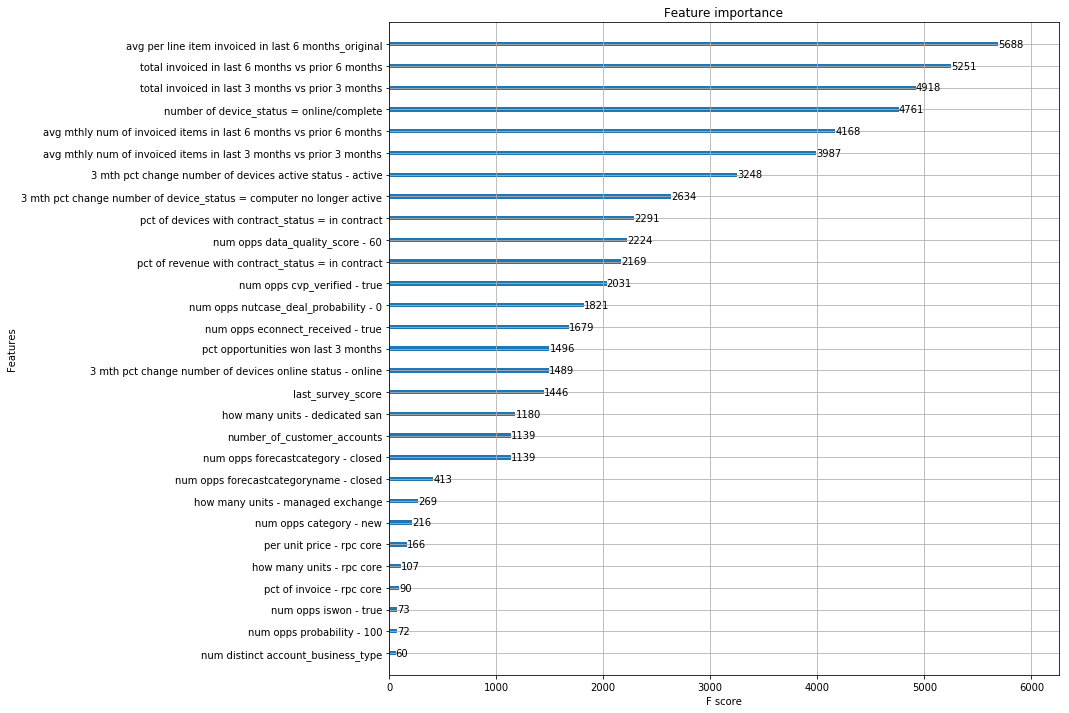

feature importance chart- gain


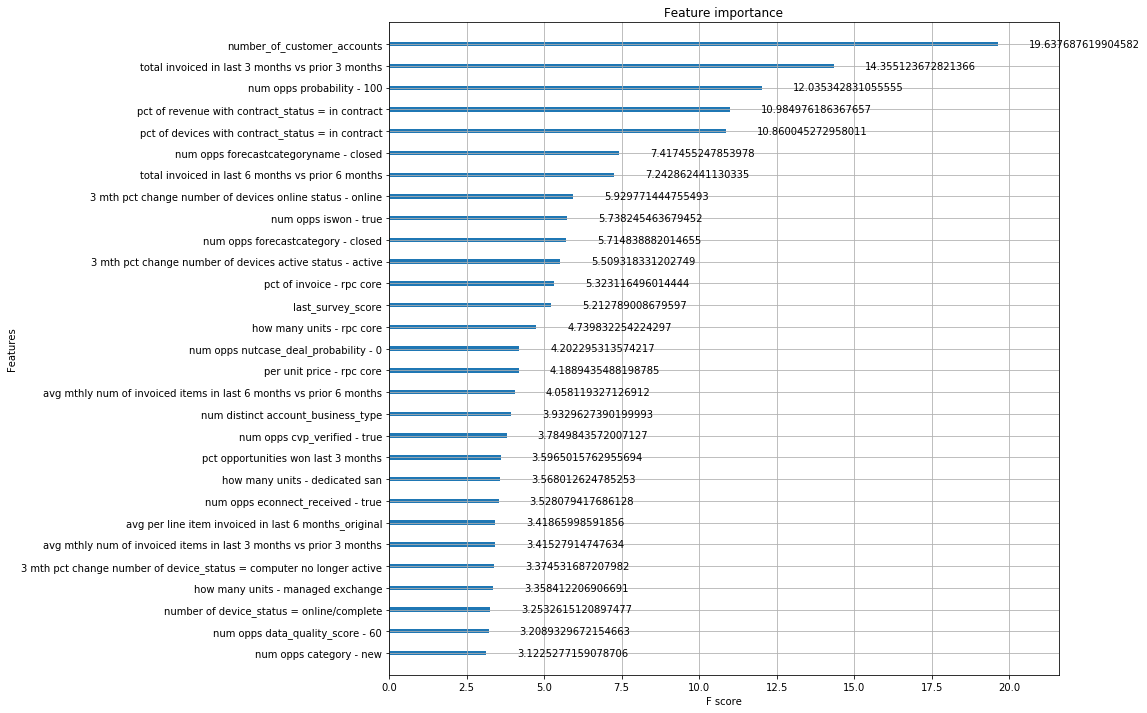

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0,
       learning_rate=0.01, max_delta_step=1, max_depth=11,
       min_child_weight=1, missing=None, n_estimators=1006, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=17,
       reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7, verbosity=0)

feature importance chart - mid


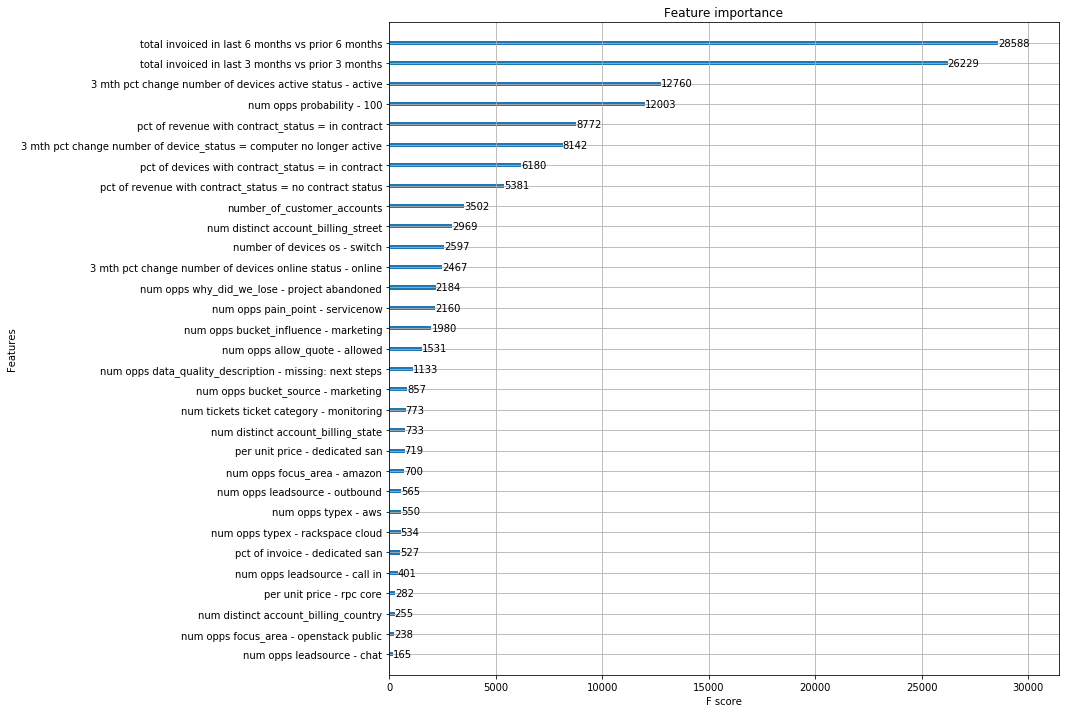

feature importance chart- gain


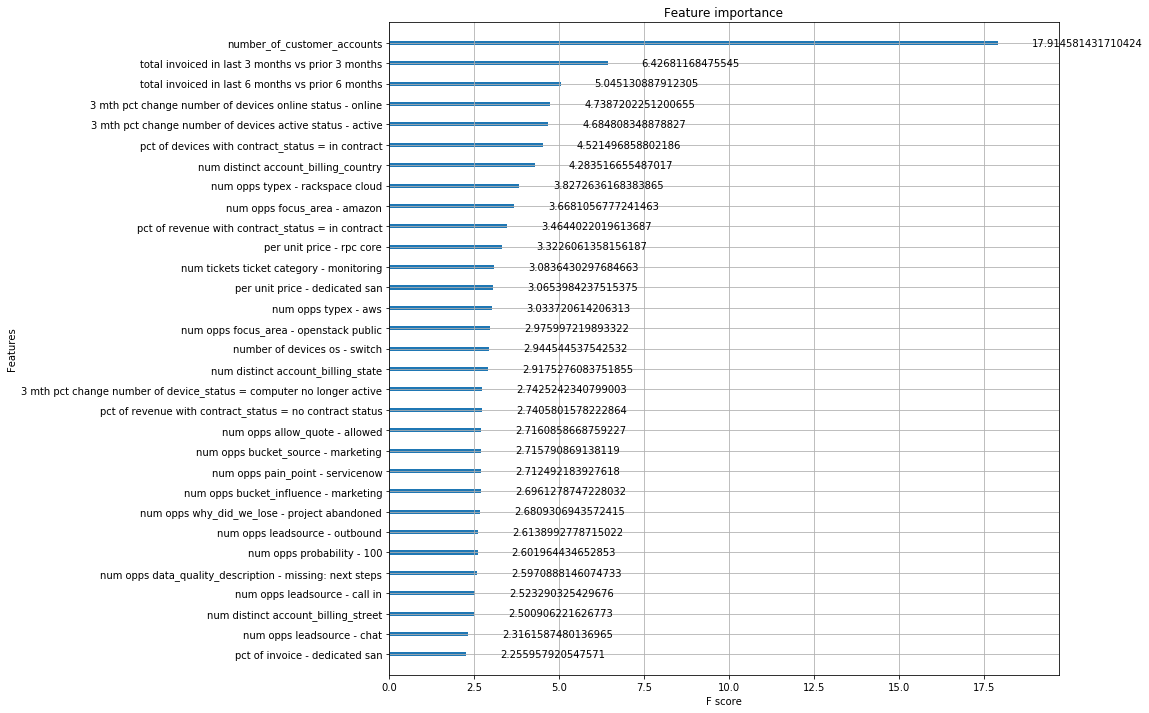

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, eval_metric='auc', gamma=0,
       learning_rate=0.02, max_delta_step=2, max_depth=14,
       min_child_weight=0, missing=None, n_estimators=756, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=17,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

feature importance chart - low


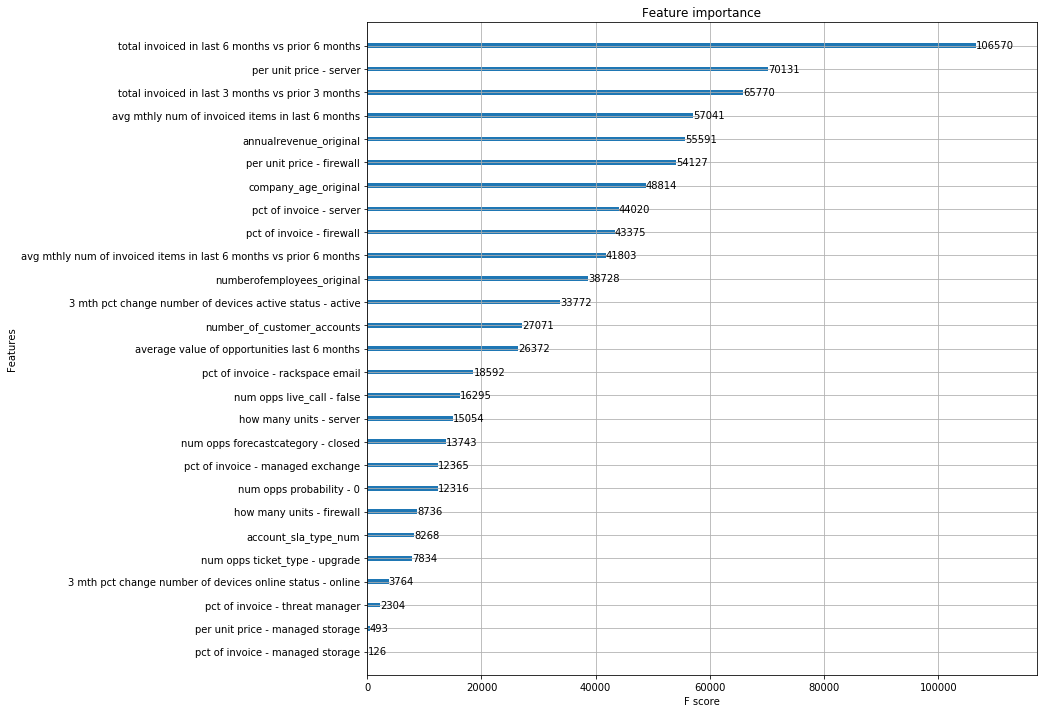

feature importance chart- gain


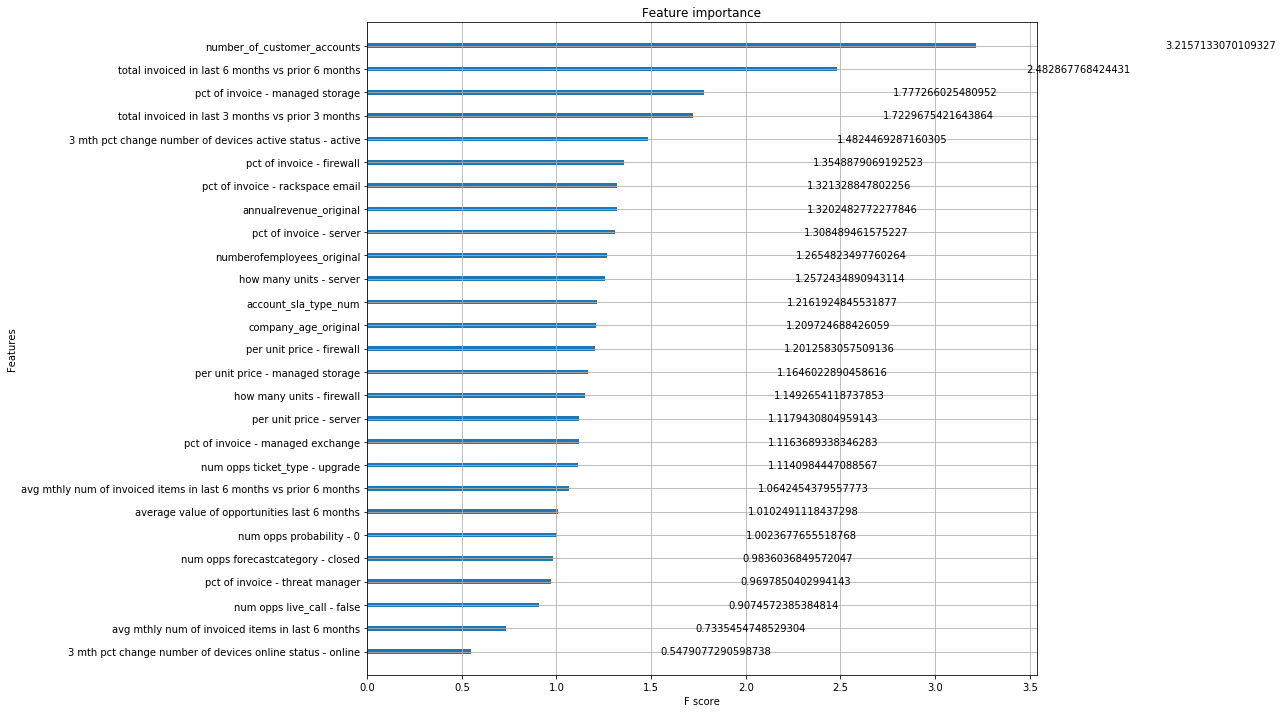

In [18]:
# create most recent feature importance plot for latest model : gbm_final_low, gbm_final_mid, gbm_final_hi
import matplotlib.pyplot as pyplot
from xgboost import plot_importance

rcParams['figure.figsize'] = 12, 12
fi_low = pd.concat([pd.DataFrame(predictors_low),pd.DataFrame(xgb_final_low.feature_importances_)], axis=1)
fi_low.columns=['features','feature importance']
fi_mid = pd.concat([pd.DataFrame(predictors_mid),pd.DataFrame(xgb_final_mid.feature_importances_)], axis=1)
fi_mid.columns=['features','feature importance']
fi_hi = pd.concat([pd.DataFrame(predictors_hi),pd.DataFrame(xgb_final_hi.feature_importances_)], axis=1)
fi_hi.columns=['features','feature importance']


# High Value Accounts
#print(fi_hi)
print(xgb_final_hi)

print('\nfeature importance chart - hi')
plot_importance(xgb_final_hi)
pyplot.show()
#print('feature importance chart- cover')
#plot_importance(xgb_final_hi, importance_type="cover")
pyplot.show()
print('feature importance chart- gain')
plot_importance(xgb_final_hi, importance_type="gain")
pyplot.show()

#Mid Value Accounts
#print(fi_mid)
print(xgb_final_mid)

print('\nfeature importance chart - mid')
plot_importance(xgb_final_mid)
pyplot.show()
#print('feature importance chart- cover')
#plot_importance(xgb_final_mid, importance_type="cover")
pyplot.show()
print('feature importance chart- gain')
plot_importance(xgb_final_mid, importance_type="gain")
pyplot.show()

#Low Value Accounts
#print(fi_low)
print(xgb_final_low)

import matplotlib.pyplot as pyplot

print('\nfeature importance chart - low')
plot_importance(xgb_final_low)
pyplot.show()
#print('feature importance chart- cover')
#plot_importance(xgb_final_low, importance_type="cover")
pyplot.show()
print('feature importance chart- gain')
plot_importance(xgb_final_low, importance_type="gain")
pyplot.show()

In [ ]:
from xgboost import plot_tree
plot_tree(xgb_final_hi) #this feature won't work if white spaces are in the feature names.. which are in almost all of them